# Imports

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import scipy.interpolate
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

# Plot cosmetics

In [2]:
# sizes
suptitle_size = 24
title_size = 20
axislabel_size = 18
axisticklabel_size = 18
axistick_size = 18


# colors
black_color = (0.1, 0.1, 0.1)
gray_color = (0.3, 0.3, 0.3)

# Load data

In [3]:
file_path = 'data'
file_handle = open(file_path, 'r')
reader = csv.reader(file_handle, delimiter = '\t')

In [4]:
data_df = pd.read_csv(file_path, delimiter = '\t', header = 0)

In [5]:
data_df.head()

,time,theta,alt,v
0,109,-11.0,9750,472
1,111,-10.0,9530,480
2,113,-7.5,9250,488
3,115,0.0,9100,490
4,116,5.5,9110,489


In [6]:
def mph_to_fps(num):
    feet_per_mile = 5280
    seconds_per_hour = 3600
    return num*feet_per_mile/seconds_per_hour

In [7]:
data_np = data_df.values

In [8]:
# Set t0 = 0
data_np[:,0] = data_np[:,0] - data_np[0,0]

# Convert mph to feet per sec
data_np[:,3] = np.apply_along_axis(mph_to_fps, 0, data_np[:,3])

### Preprocess raw data:
- Gaussian filter to smooth
- 1D interpolation to increase number of data points

In [9]:
sigma = 1

t = scipy.interpolate.interp1d(range(data_np.shape[0]), gaussian_filter(data_np[:,0], sigma))
t_list = [float(t(i/1000.*(data_np.shape[0]-1))) for i in range(1001)]

theta = scipy.interpolate.interp1d(range(data_np.shape[0]), gaussian_filter(data_np[:,1], sigma))
theta_list = [float(theta(i/1000.*(data_np.shape[0]-1))) for i in range(1001)]

alt = scipy.interpolate.interp1d(range(data_np.shape[0]), gaussian_filter(data_np[:,2], sigma))
alt_list = [float(alt(i/1000.*(data_np.shape[0]-1))) for i in range(1001)]

v = scipy.interpolate.interp1d(range(data_np.shape[0]), gaussian_filter(data_np[:,3], sigma))
v_list = [float(v(i/1000.*(data_np.shape[0]-1))) for i in range(1001)]

# Plots

### Plot raw and processed data

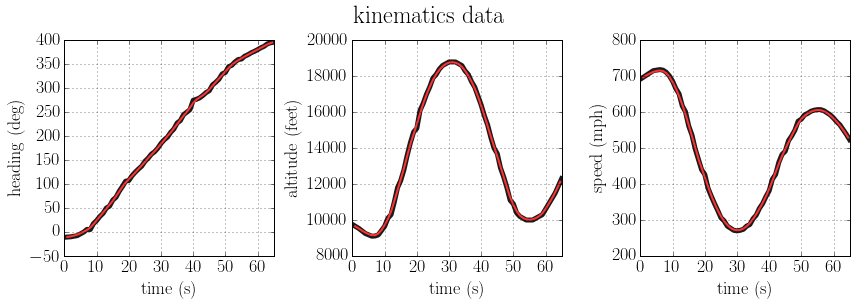

In [10]:
fig = plt.figure(figsize = (12,4))
fig.suptitle('kinematics data', size = suptitle_size, y = 1.05)

plt.subplot(1, 3, 1)
plt.plot(data_np[:,0], data_np[:,1], c = black_color, lw = 5)
plt.plot(t_list, theta_list, c = (1,.2,.2), lw = 2)
plt.grid()
plt.xlim(np.min(data_np[:,0]), np.max(data_np[:,0]))
plt.tick_params(labelsize = axisticklabel_size)
plt.xlabel('time (s)', size = axislabel_size)
plt.ylabel('heading (deg)', size = axislabel_size)

plt.subplot(1, 3, 2)
plt.plot(data_np[:,0], data_np[:,2], c = black_color, lw = 5)
plt.plot(t_list, alt_list, c = (1,.2,.2), lw = 2)
plt.grid()
plt.xlim(np.min(data_np[:,0]), np.max(data_np[:,0]))
plt.tick_params(labelsize = axisticklabel_size)
plt.xlabel('time (s)', size = axislabel_size)
plt.ylabel('altitude (feet)', size = axislabel_size)

plt.subplot(1, 3, 3)
plt.plot(data_np[:,0], data_np[:,3], c = black_color, lw = 5)
plt.plot(t_list, v_list, c = (1,.2,.2), lw = 2)
plt.grid()
plt.xlim(np.min(data_np[:,0]), np.max(data_np[:,0]))
plt.tick_params(labelsize = axisticklabel_size)
plt.xlabel('time (s)', size = axislabel_size)
plt.ylabel('speed (mph)', size = axislabel_size)

    
    
fig.tight_layout()
    
plt.show()

# Calculate x, y vs t

In [11]:
# All angles need to be converted to rad
def to_rad(ang):
    return ang*2*3.14159/360.0

### Calculate x and y, the lateral and altitude displacement of jet
$$\vec{x}\left(t_{i}\right) = \vec{x}\left(t_{i-1}\right)+\vec{v}\left(t_{i-1}\right)\cdot\Delta t+ \frac{1}{2}\vec{a}\left(t_{i}\right)*\Delta t^{2}$$


$$\vec{a}\left(t\right) = \frac{\Delta \vec{v}}{\Delta t} = \frac{\left[\vec{v}\left(t_{i}\right)-\vec{v}\left(t_{i-1}\right)\right]}{\Delta t}$$

In [12]:
# x and y are the lateral and altitude displacement of the jet, respectively

x = np.empty(len(t_list))
x[0] = 0

y = np.empty(len(t_list))
y[0] = alt_list[0]

for i in range(1,len(t_list)):
    # v*cos(theta)*time + x[time-1]
    
    theta = to_rad(theta_list[i-1])
    
    dt = t_list[i]-t_list[i-1]
    
    v = v_list[i-1]
    vx = v*math.cos(theta)
    vy = v*math.sin(theta)
    
    ax = (v_list[i]*math.cos(to_rad(theta_list[i])) - vx)/dt
    ay = (v_list[i]*math.sin(to_rad(theta_list[i])) - vy)/dt
        
    
    x[i] = x[i-1] + vx*dt + .5*ax*dt**2.
    y[i] = y[i-1] + vy*dt + .5*ay*dt**2.

### Compare predicted altitude (y) vs altitude from data

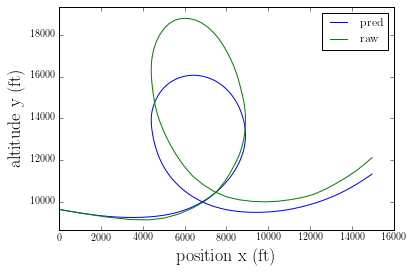

In [13]:
plt.plot(x, y, label = 'pred')
plt.plot(x, alt_list, label = 'raw')
plt.legend()
plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('position x (ft)', size = axislabel_size)
plt.ylabel('altitude y (ft)', size = axislabel_size)
plt.show()

# Plot trajectory

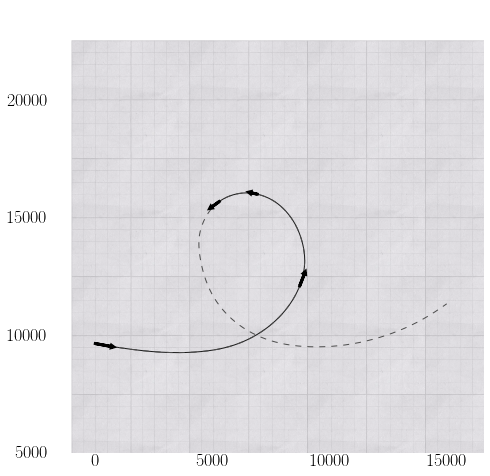

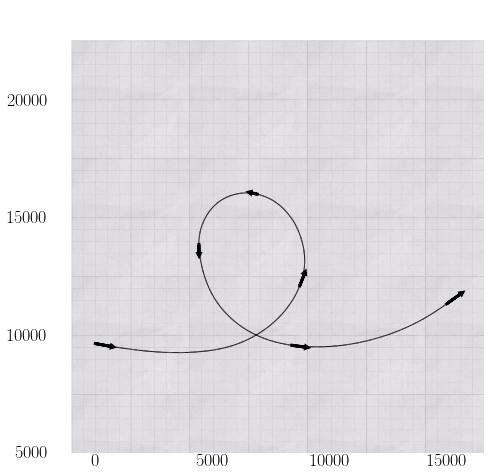

In [38]:
step_size = 0.05
frames_per_sec = 30
num_frames = 2

background = mpimg.imread('background.png') # Smarter Every Day graph paper loda

special_t = [0, 200, 400, 600, 800, 999] # Times that we want arrows to remain at



for i in range(0, num_frames):
    t = int((i+1.)/num_frames*len(x) - 1)    
    
    # Set up the plot
    fig = plt.figure(figsize = (8,8))
    ax = plt.gca()
    
    # Plot line
    plt.plot(x[:t], y[:t], color = black_color)
    
    plt.plot(x, y, ls = '--', color = gray_color)
    
    
    # Plot arrow
    theta = theta_list[t]
    vscaled = 1000*v_list[t]/np.max(data_np[:,3])
    ax.arrow(x[t], y[t], vscaled*math.cos(to_rad(theta)), vscaled*math.sin(to_rad(theta)),\
             head_width = 100, head_length = 100, lw = 3, zorder = 100)
    
    t_del = 50
    for spec_t in special_t:
        if t-t_del > spec_t:
            
            special_theta = theta_list[spec_t]
            special_v = v_list[spec_t]
            ax.arrow(x[spec_t], y[spec_t],\
                 special_v*math.cos(to_rad(special_theta)), special_v*math.sin(to_rad(special_theta)),\
             head_width = 100, head_length = 100, lw = 3, zorder = 100)

        
    # Add background image
    
    #de = 14050+2100
    
    

    
    
    
    #plt.xticks([2500*j for j in range(6)], [str(2500*j) for j in range(6)])
    #plt.yticks([5000+2500*j for j in range(6)], [str(5000+2500*j) for j in range(6)])
    
    plt.tick_params(bottom = 'off', top = 'off', left = 'off', right = 'off',\
                    labelsize = axistick_size, pad = 0)
    #plt.yticks([])
    #plt.xticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    #ax.set_aspect('equal', 'datalim')
    plt.gca().set_aspect('equal', adjustable='box')
    xr = 19000
    yr = xr*8./8.
    plt.xlim(-2000, 16500)
    plt.ylim(5000, 5000 + yr)
    
    de = 20000
    
    exi = -1000
    exf = exi + de
    eyi = 2500
    eyf = eyi + de
    plt.imshow(background, extent = [exi, exf, eyi, eyf], aspect = 'equal')
    #plt.axis('equal')

    
    #plt.savefig('./output/'+str(i)+'.png', dpi = 300)
    
    plt.show()